# Project 3 Natural Language Processing to Classify Subreddit Posts

In [2]:
import wordcloud
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time, datetime
import regex as re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.datasets import make_classification
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

# Retrieving Subreddit #0 Data (Political Discussion)

In [2]:
base_url = 'https://api.pushshift.io/reddit/search/submission/?'
before_utc = 1580414666
params = {
    'subreddit' : 'PoliticalDiscussion',
    'is_video' : 'false',
    'size' : 1000,
    'after' : 1420070400,     # the first second of 2015
    'before': before_utc,     # Thursday, Jan 2020, 2:04pm
    'sort' : 'desc'
}

political_disc_res_batch1 = requests.get(base_url, params)
before_utc = 1578537450 # re-assigning this variable to grab next 1000 with next request
political_disc_res_batch2 = requests.get(base_url, params)
before_utc = 1576640482
political_disc_res_batch3 = requests.get(base_url, params)

In [3]:
political_disc_res_df = pd.DataFrame(political_disc_res_batch1.json()['data']) # json makes it a python dictionary. Figure out the pattern.
political_disc_res_df.shape
political_disc_res_df2 = pd.DataFrame(political_disc_res_batch2.json()['data']) # json makes it a python dictionary. Figure out the pattern.
political_disc_res_df3 = pd.DataFrame(political_disc_res_batch2.json()['data']) # json makes it a python dictionary. Figure out the pattern.
print(f'political_disc_res_df shape: {political_disc_res_df.shape}')
print(f'political_disc_res_df2 shape: {political_disc_res_df2.shape}')
print(f'political_disc_res_df3 shape: {political_disc_res_df3.shape}')

political_disc_res_df shape: (1000, 68)
political_disc_res_df2 shape: (1000, 68)
political_disc_res_df3 shape: (1000, 68)


In [4]:
political_disc_res_df = pd.concat((political_disc_res_df, political_disc_res_df2, political_disc_res_df3), ignore_index=True, sort=False)

In [5]:
political_disc_res_df = political_disc_res_df[['author', 'gildings', 'id', 'num_comments', 'num_crossposts', 'score', 'selftext', 'subreddit', 'title', 'total_awards_received']]

In [6]:
political_disc_res_df

,author,gildings,id,num_comments,num_crossposts,score,selftext,subreddit,title,total_awards_received
0,spadafuoco,{},ewb35k,2,0,1,[removed],PoliticalDiscussion,If relevant information from a foreign country...,0
1,jtaustin64,{},ewb05x,2,0,1,[removed],PoliticalDiscussion,Marriage Counseling or Divorce: the state of t...,0
2,azerty1977,{},ewav19,2,0,1,[removed],PoliticalDiscussion,We need both sides in politics,0
3,Go2102,{},ewa1vs,2,0,1,[removed],PoliticalDiscussion,Power,0
4,allday_viking,{},ew9m9q,2,0,1,[removed],PoliticalDiscussion,Why does anyone care about the impeachment?,0
...,...,...,...,...,...,...,...,...,...,...
2995,sheepa711,{},em5ish,0,0,1,[removed],PoliticalDiscussion,Australian politics,0
2996,Phantom-Renegade,{},em50c1,2,0,1,[removed],PoliticalDiscussion,Is there a modern day equivalent or something ...,0
2997,RookieRobot,{},em4px7,2,0,1,[removed],PoliticalDiscussion,Could Trump attacking Iran actually be a campa...,0
2998,jeastmanfalley,{},em4b84,0,0,1,[removed],PoliticalDiscussion,2020,0


# Retrieving Subreddit #1 Data (Neutral Politics)

In [7]:
base_url = 'https://api.pushshift.io/reddit/search/submission/?'
before_utc = 1580414666
params = {
    'subreddit' : 'NeutralPolitics',
    'is_video' : 'false',
    'size' : 1000,
    'after' : 1420070400, # the first second of 2015
    'before': before_utc, # the last second of 2019
    'sort' : 'desc'
}

neutralpolitics_res_batch1 = requests.get(base_url, params)
before_utc = 1562566499
params = {
    'subreddit' : 'NeutralPolitics',
    'is_video' : 'false',
    'size' : 1000,
    'after' : 1420070400, # the first second of 2015
    'before': before_utc, # the last second of 2019
    'sort' : 'desc'
}
neutralpolitics_res_batch2 = requests.get(base_url, params)
before_utc = 1548965464
params = {
    'subreddit' : 'NeutralPolitics',
    'is_video' : 'false',
    'size' : 1000,
    'after' : 1420070400, # the first second of 2015
    'before': before_utc, # the last second of 2019
    'sort' : 'desc'
}
neutralpolitics_res_batch3 = requests.get(base_url, params)

In [8]:
neutralpolitics_res_df = pd.DataFrame(neutralpolitics_res_batch1.json()['data'])
neutralpolitics_res_df2 = pd.DataFrame(neutralpolitics_res_batch2.json()['data'])
neutralpolitics_res_df3 = pd.DataFrame(neutralpolitics_res_batch3.json()['data'])
print(f'neutralpolitics_res_df shape: {neutralpolitics_res_df.shape}')
print(f'neutralpolitics_res_df2 shape: {neutralpolitics_res_df2.shape}')
print(f'neutralpolitics_res_df3 shape: {neutralpolitics_res_df3.shape}')

neutralpolitics_res_df shape: (1000, 70)
neutralpolitics_res_df2 shape: (1000, 70)
neutralpolitics_res_df3 shape: (1000, 70)


In [9]:
neutralpolitics_res_df = pd.concat((neutralpolitics_res_df, neutralpolitics_res_df2, neutralpolitics_res_df3), ignore_index=True, sort=False)

In [10]:
neutralpolitics_res_df = neutralpolitics_res_df[['author', 'gildings', 'id', 'num_comments', 'num_crossposts', 'score', 'selftext', 'subreddit', 'title']]
neutralpolitics_res_df.shape

(3000, 9)

In [11]:
neutralpolitics_res_df

,author,gildings,id,num_comments,num_crossposts,score,selftext,subreddit,title
0,mewthulhu,{},ewa0cq,5,0,1,[removed],NeutralPolitics,"Australian here: Last time with reddit, we got..."
1,beardlessdick,{},ew91ft,2,0,1,[removed],NeutralPolitics,What are the ramifications of the increased us...
2,clarenceappendix,{},ew8uwh,5,0,1,[removed],NeutralPolitics,Has anyone actually changed Steven Crowder's m...
3,crysumkas,{},ew6vhh,3,0,1,[removed],NeutralPolitics,Would the Ukraine events still be an issue if ...
4,itripballs,{},ew6h0g,4,0,1,[removed],NeutralPolitics,Are Farage criticisms of European Union valid?
...,...,...,...,...,...,...,...,...,...
2995,DemsAreToast2020,{},catg25,2,0,1,[removed],NeutralPolitics,Why is there an issue with asking if you're a ...
2996,MustLetTomPickOnion,{},caqwnc,1,0,1,[removed],NeutralPolitics,If the citizenship question was on the census ...
2997,Venom1991,{},caqi3o,4,0,1,[removed],NeutralPolitics,Help me to make sense of election statistics
2998,Aabroo-Cool003,{},caj33x,1,0,1,[removed],NeutralPolitics,A new Qatari conspiracy was revealed a couple ...


# Pre-Processing 

When dealing with text data, there are common pre-processing steps. In this project I decided to manually Tokenize using RegEx, use the stopwords from nltk.corpus and add my own stopwords that were relevant to my observations.
- Tokenizing
- Stopwords
- Lemmatizing/Stemming
- Cleaning (i.e. removing HTML)

## Manual Tokenizing

In [12]:
political_disc_res_df['title'] # dtype object, column with rows of text, not a list.

0       If relevant information from a foreign country...
1       Marriage Counseling or Divorce: the state of t...
2                          We need both sides in politics
3                                                   Power
4             Why does anyone care about the impeachment?
                              ...                        
2995                                  Australian politics
2996    Is there a modern day equivalent or something ...
2997    Could Trump attacking Iran actually be a campa...
2998                                                 2020
2999                               Is Taxation Extortion?
Name: title, Length: 3000, dtype: object

In [13]:
# Instantiate Tokenizer.
tokenizer = RegexpTokenizer(r'\w+')
# "Run" Tokenizer on title columns using .apply and lambda functions.
# Code modified from Rachel Koenig:
# https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
political_disc_res_df['title'] = political_disc_res_df['title'].apply(lambda x: tokenizer.tokenize(x.lower()))
neutralpolitics_res_df['title'] = neutralpolitics_res_df['title'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [14]:
# Filling na values of selftext columns with their subreddit name since stopwords will remove it down the line
political_disc_res_df['selftext'] = political_disc_res_df['selftext'].fillna(value='PoliticalDiscussion')
political_disc_res_df['selftext'] = political_disc_res_df['selftext'].apply(lambda x: tokenizer.tokenize(x.lower()))
neutralpolitics_res_df['selftext'] = neutralpolitics_res_df['selftext'].fillna(value='neutralpolitics')
neutralpolitics_res_df['selftext'] = neutralpolitics_res_df['selftext'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [15]:
political_disc_res_df['title'] # after tokenizing I have a column with rows of lists containing comma'd text

0       [if, relevant, information, from, a, foreign, ...
1       [marriage, counseling, or, divorce, the, state...
2                   [we, need, both, sides, in, politics]
3                                                 [power]
4       [why, does, anyone, care, about, the, impeachm...
                              ...                        
2995                               [australian, politics]
2996    [is, there, a, modern, day, equivalent, or, so...
2997    [could, trump, attacking, iran, actually, be, ...
2998                                               [2020]
2999                            [is, taxation, extortion]
Name: title, Length: 3000, dtype: object

## Setting up and then Removing Stop Words

In [16]:
# Creating a set out of the stopwords so I can easily add my own, also faster computing
stopset = set(stopwords.words('english'))
stopset.update({'http', 'https', 'www', 'neutral', 'org', 'remove', 'removed'})

In [19]:
def remove_stopwords(text): # created function to remove stopwords
    words = [words for words in text if words not in stopset]
    return words
# https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
political_disc_res_df['title'] = political_disc_res_df['title'].apply(lambda x: remove_stopwords(x))
neutralpolitics_res_df['title'] = neutralpolitics_res_df['title'].apply(lambda x: remove_stopwords(x))

In [20]:
political_disc_res_df['title'].head() # checking to see that stopwords have been removed but text still in lists and comma'd out

0    [relevant, information, foreign, country, poli...
1    [marriage, counseling, divorce, state, damage,...
2                              [need, sides, politics]
3                                              [power]
4                          [anyone, care, impeachment]
Name: title, dtype: object

In [21]:
neutralpolitics_res_df['title'].head() 

0    [australian, last, time, reddit, got, biased, ...
1    [ramifications, increased, usage, executive, o...
2    [anyone, actually, changed, steven, crowder, m...
3    [would, ukraine, events, still, issue, involve...
4         [farage, criticisms, european, union, valid]
Name: title, dtype: object

In [22]:
political_disc_res_df['selftext'] = political_disc_res_df['selftext'].apply(lambda x: remove_stopwords(x))
neutralpolitics_res_df['selftext'] = neutralpolitics_res_df['selftext'].apply(lambda x: remove_stopwords(x))

In [23]:
neutralpolitics_res_df['selftext'].shape # checking that I still have my correct shape

(3000,)

In [24]:
neutralpolitics_res_df['title'].shape # checking that I still have my correct shape

(3000,)

In [25]:
political_disc_res_df['selftext'].shape # doubl

(3000,)

In [26]:
political_disc_res_df['title'].shape

(3000,)

If we think about stemming/lemmatizing as models...
- Stemming tends to minimize false negatives. (Errs on the side of stemming more than it should.)
- Lemmatizing tends to minimize false positives. (Errs on the side of lemmatizing less than it should.)

#### Lemmtatizing the Tokens

In [27]:
lemmatizer = WordNetLemmatizer() # Minimizes false positives, more cautious and gentle than stemming
# https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

political_disc_res_df['title'] = political_disc_res_df['title'].apply(lambda x: word_lemmatizer(x))
neutralpolitics_res_df['title'] = neutralpolitics_res_df['title'].apply(lambda x: word_lemmatizer(x))

political_disc_res_df['selftext'] = political_disc_res_df['selftext'].apply(lambda x: word_lemmatizer(x))
neutralpolitics_res_df['selftext'] = neutralpolitics_res_df['selftext'].apply(lambda x: word_lemmatizer(x))

In [28]:
political_disc_res_df['title']

0       [relevant, information, foreign, country, poli...
1       [marriage, counseling, divorce, state, damage,...
2                                  [need, side, politics]
3                                                 [power]
4                             [anyone, care, impeachment]
                              ...                        
2995                               [australian, politics]
2996    [modern, day, equivalent, something, close, mu...
2997    [could, trump, attacking, iran, actually, camp...
2998                                               [2020]
2999                                [taxation, extortion]
Name: title, Length: 3000, dtype: object

In [29]:
neutralpolitics_res_df['title'] 

0       [australian, last, time, reddit, got, biased, ...
1       [ramification, increased, usage, executive, or...
2       [anyone, actually, changed, steven, crowder, m...
3       [would, ukraine, event, still, issue, involve,...
4             [farage, criticism, european, union, valid]
                              ...                        
2995               [issue, asking, citizen, 2020, census]
2996    [citizenship, question, census, obama, adminis...
2997             [help, make, sense, election, statistic]
2998    [new, qatari, conspiracy, revealed, couple, da...
2999    [evidence, pro, con, tax, rich, pension, tax, ...
Name: title, Length: 3000, dtype: object

### Stemming

In [2]:
# Instantiate object of class PorterStemmer
stemmer = PorterStemmer()

# function from https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
def word_stemmer(text):
    stem_text = " ".join([stemmer.stem(i) for i in text]) # empty string with .join gets rid of commas and spaces
    return stem_text

political_disc_res_df['title'] = political_disc_res_df['title'].apply(lambda x: word_stemmer(x))
neutralpolitics_res_df['title'] = neutralpolitics_res_df['title'].apply(lambda x: word_stemmer(x))

NameError: name 'PorterStemmer' is not defined

In [ ]:

political_disc_res_df['selftext'] = political_disc_res_df['selftext'].apply(lambda x: word_stemmer(x))
neutralpolitics_res_df['selftext'] = neutralpolitics_res_df['selftext'].apply(lambda x: word_stemmer(x))

In [31]:
political_disc_res_df['title'] # after stemming using .join the text is no longer in a list or comma'd

0       relev inform foreign countri polit nomine pres...
1        marriag counsel divorc state damag polit divid u
2                                         need side polit
3                                                   power
4                                      anyon care impeach
                              ...                        
2995                                     australian polit
2996    modern day equival someth close munich agreeme...
2997     could trump attack iran actual campaign strategi
2998                                                 2020
2999                                         taxat extort
Name: title, Length: 3000, dtype: object

In [32]:
neutralpolitics_res_df['title']

0       australian last time reddit got bias view prim...
1       ramif increas usag execut order enact polici c...
2                  anyon actual chang steven crowder mind
3       would ukrain event still issu involv biden tru...
4                       farag critic european union valid
                              ...                        
2995                          issu ask citizen 2020 censu
2996    citizenship question censu obama administr que...
2997                         help make sens elect statist
2998    new qatari conspiraci reveal coupl day ago qat...
2999    evid pro con tax rich pension tax reform 2016 ...
Name: title, Length: 3000, dtype: object

### Model Prep

In [34]:
# creatng 1 dataframe out of the 2 separate dataframes and only including the important columns
model_df = pd.concat((political_disc_res_df[['selftext', 'subreddit', 'title']],
                      neutralpolitics_res_df[['selftext', 'subreddit', 'title']]),
                    ignore_index=True, sort=False)

model_df

,selftext,subreddit,title
0,,PoliticalDiscussion,relev inform foreign countri polit nomine pres...
1,,PoliticalDiscussion,marriag counsel divorc state damag polit divid u
2,,PoliticalDiscussion,need side polit
3,,PoliticalDiscussion,power
4,,PoliticalDiscussion,anyon care impeach
...,...,...,...
5995,,NeutralPolitics,issu ask citizen 2020 censu
5996,,NeutralPolitics,citizenship question censu obama administr que...
5997,,NeutralPolitics,help make sens elect statist
5998,,NeutralPolitics,new qatari conspiraci reveal coupl day ago qat...


In [83]:
# Code from my colleague Amit Marwaha. Combining selftext and title columns/series to have more data for my model
model_df['selftext_and_title'] = model_df['selftext'] + '' + model_df['title']

In [84]:
model_df # checking for successful addition of selftext & title column

,selftext,subreddit,title,selftext_and_title
0,,PoliticalDiscussion,relev inform foreign countri polit nomine pres...,relev inform foreign countri polit nomine pres...
1,,PoliticalDiscussion,marriag counsel divorc state damag polit divid u,marriag counsel divorc state damag polit divid u
2,,PoliticalDiscussion,need side polit,need side polit
3,,PoliticalDiscussion,power,power
4,,PoliticalDiscussion,anyon care impeach,anyon care impeach
...,...,...,...,...
1995,,NeutralPolitics,issu ask citizen 2020 censu,issu ask citizen 2020 censu
1996,,NeutralPolitics,citizenship question censu obama administr que...,citizenship question censu obama administr que...
1997,,NeutralPolitics,help make sens elect statist,help make sens elect statist
1998,,NeutralPolitics,new qatari conspiraci reveal coupl day ago qat...,new qatari conspiraci reveal coupl day ago qat...


In [43]:
# Setting my X & y variables and checking the baseline
X = model_df['selftext_and_title']
y = model_df['subreddit']
y.value_counts(normalize=True)

NeutralPolitics        0.5
PoliticalDiscussion    0.5
Name: subreddit, dtype: float64

# Initial train_test_split & Experimentation/Visualization

In [298]:
X_train, X_test, y_train, y_test = train_test_split(model_df['selftext_and_title'],
                                                    model_df['subreddit'],
                                                    test_size = 0.33, # 33% test size
                                                    random_state = 78741)

#### Example/Experimentation from General Assembly Local Lecture

In [299]:
cvec = CountVectorizer(min_df=3) # Instantiating Count Vectorizer and minimizing to 3 trims because many 1-time only words make noise for the model
X_train_cvec = cvec.fit_transform(X_train) # fitting and transforming X_train data. Still just a sparse matrix like this
# .getfeaturenames creates columns here, .todense makes the sparse matrix a matrix that can be dataframed
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names())

X_test_cvec = cvec.transform(X_test) # doing the same as above with X_test but only transforming
X_test_df = pd.DataFrame(X_test_cvec.todense(), \
                         columns = cvec.get_feature_names())

In [300]:
X_train_df.head()

,000,01,015016988,02,03,04,041515,05,06,07,08,09,10,100,1000,11,11565182342,11567778958,116th,1194361059479576577,11e9,11ea,12,123,1232501,1284178,13,14,15,16,1609198,17,18,18836509,19,1953,1975,1975_australian_constitutional_crisi,1979,1982,1986,1989,1990,1992,1993,1995,1st,20,2008,2011,20110826043422,2012,2013,2014,2015,20158307585163273,2016,2017,2018,2019,20190115,20191203_,2019_hong_kong_anti,2020,20impeach,20of,20sign,20term,21,22,23,24,25,2639378,27,27th,2895702,2a,2b077c436617_stori,2nd,2ndamend,30,300,31,3305675,3886ecb25be54066a393c40dec81e384,389,38th,39092315,3rd,400,4121,43,4368393,442121,47889404,48,48781652,49960677,4c30,...,watch,watchdog,water,wave,way,wayofthebern,wcm,weak,weaker,wealth,wealthi,weapon,weaponri,wear,web,websit,week,weekli,weight,welchem,welcom,welfar,well,west,western,westminst,what,whatev,whenev,whether,whip,whistleblow,white,whitehous,whoever,whole,wide,wiki,wiki_sourc,wikipedia,wildfir,wildlif,william,williamson,willing,win,wind,windfal,windspeak,wing,winger,winner,winter,wise,wish,wit,withdraw,withdrew,withheld,withhold,within,without,woke,woman,wonder,wont,word,work,worker,world,wormer,wors,worst,would,wp,write,written,wrong,wrongdo,wsj,wuhan,wurd,ww2,wwiii,xi,yahoo,yang,ye,year,yemen,yesterday,yet,york,young,young_dweeziconstitution,youtu,youtub,zelenski,zero,án
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


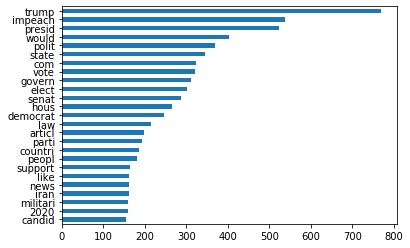

In [301]:
X_train_df.sum().sort_values().tail(25).plot.barh(); # checking most popular words across both subreddits
plt.savefig('Most Popular Words.png') # not much change in top words. more trump though

### LogReg & Confusion Matrix

In [302]:
lr = LogisticRegression(solver='liblinear') # instantiating
lr.fit(X_train_df, y_train) # fitting
print(f'Logistic Regression CVec Score: {lr.score(X_test_df, y_test)}') # checking score

Logistic Regression CVec Score: 0.8914141414141414


In [304]:
preds = lr.predict(X_test_df) # Must store predictions so we can use it in confusion matrix
cols = 'Preds: ' + lr.classes_
rows = 'Actual: ' + lr.classes_ 
pd.DataFrame(confusion_matrix(y_test, preds), columns=cols, index=rows)# using predictions vs y_test for our confusion matrix

,Preds: NeutralPolitics,Preds: PoliticalDiscussion
Actual: NeutralPolitics,861,128
Actual: PoliticalDiscussion,87,904


In [305]:
844 + 71 + 145 + 920

1980

In [307]:
np.e**1.4

4.055199966844674

In [308]:
### Let's do the same as above but move it into a function:
## Instantiate a countvectorizer object - fit transform and then put the results in a dataframe
# Code adapted from General Assembly Instructor J Beightol
def run_lrmodel_view_coef(ngram__range, min__df):

    cv = CountVectorizer(min_df=min__df, ngram_range=ngram__range)

    X_train_vect = cv.fit_transform(X_train)
    lr = LogisticRegression(solver='lbfgs')
    
    X_test_vect = cv.transform(X_test)

    lr.fit(X_train_vect, y_train)
    preds = lr.predict(X_test_vect)    
        
    print(f"accuracy score: {lr.score(X_test_vect, y_test)}")
    cols = 'Pred: ' + lr.classes_
    rows = 'Actual: ' + lr.classes_ 
    
    display(pd.DataFrame(confusion_matrix(y_test, preds), columns=cols, index=rows))
    
    fig , ax = plt.subplots(figsize=(12,12))
        
    coef_df = pd.DataFrame(lr.coef_, columns=cv.get_feature_names()).T
    coef_df['ABS'] = coef_df[0].abs()
    coef_df.sort_values('ABS').tail(20).loc[:,0].plot.barh(ax=ax);
    ax.set_title('Subreddit Coefficients Double Ngram');
    plt.savefig('Subreddit Coefficients.png', facecolor='w')

accuracy score: 0.9691919191919192


,Pred: NeutralPolitics,Pred: PoliticalDiscussion
Actual: NeutralPolitics,934,55
Actual: PoliticalDiscussion,6,985


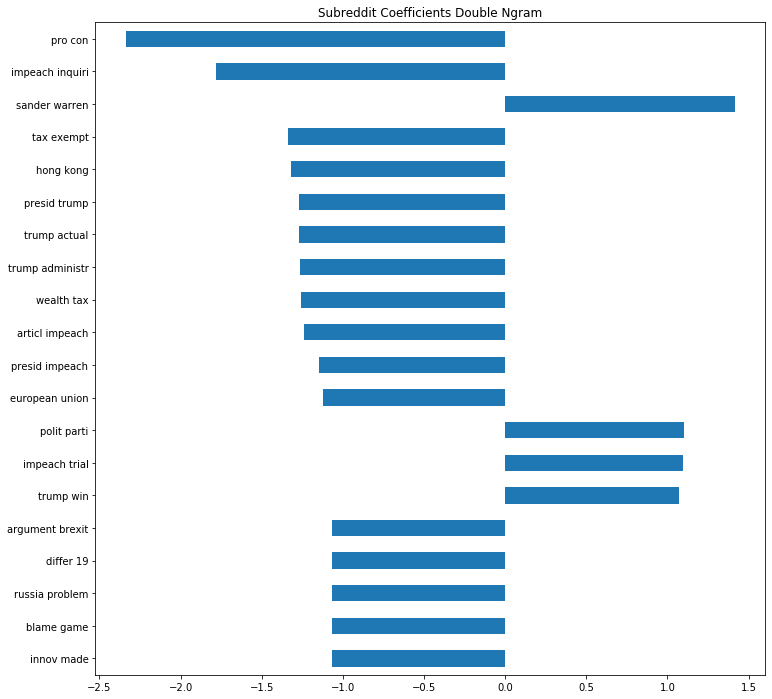

In [309]:
run_lrmodel_view_coef((2, 2), 1)
plt.savefig('Subreddit Coefficients Double Ngram.png', facecolor='w', bbox_inches='tight')

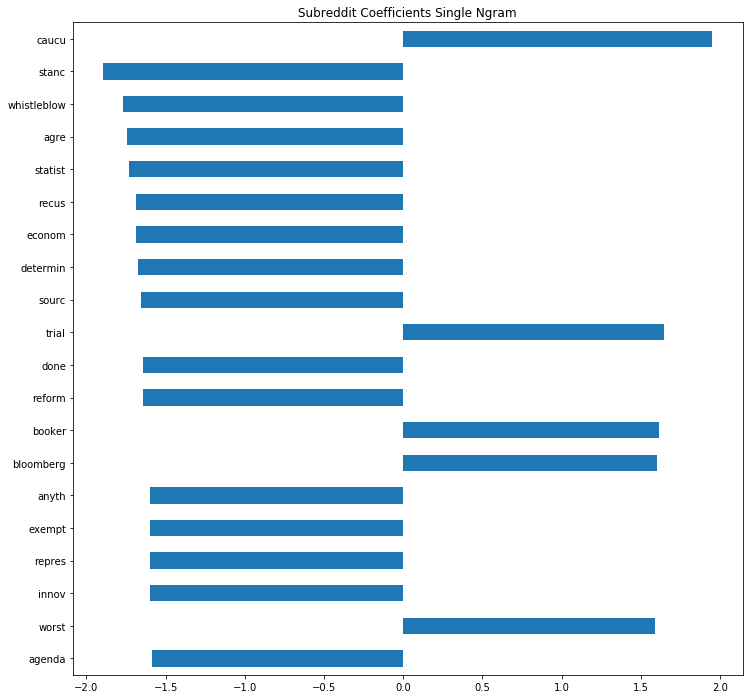

In [310]:
fig , ax = plt.subplots(figsize=(12,12))
coef_df = pd.DataFrame(lr.coef_, columns=cvec.get_feature_names()).T
coef_df['ABS'] = coef_df[0].abs()
coef_df.sort_values('ABS').tail(20).loc[:,0].plot.barh(ax=ax);
# left going is zero(Neutral Politics), right is 1 (Political Discussion)
#easili is 1.4 to the e (405%) as liklely to be included in change my view
ax.set_title('Subreddit Coefficients Single Ngram');
plt.savefig('Subreddit Coefficients.png', facecolor='w', bbox_inches='tight')

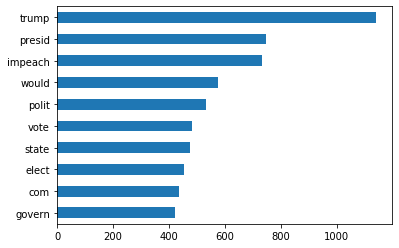

In [311]:
cvec = CountVectorizer(min_df=6)
vect_df = pd.DataFrame(cvec.fit_transform(model_df['selftext_and_title']).todense(),
                      columns = cvec.get_feature_names())
vect_df.sum().sort_values().tail(10).plot.barh();

In [312]:
political_disc_df = vect_df[model_df['subreddit'] =='PoliticalDiscussion']
neutralpolitics_df = vect_df[model_df['subreddit'] == 'NeutralPolitics']
political_disc_df_top_words = list(vect_df.sum().sort_values().tail(15).index)
neutralpolitics_df_top_words = list(vect_df.sum().sort_values().tail(15).index)

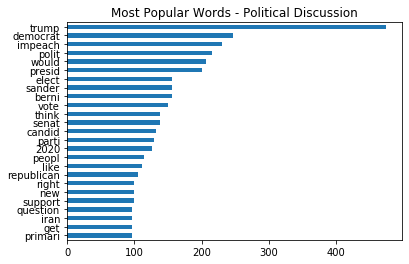

In [313]:
political_disc_df.sum().sort_values().tail(25).plot.barh(title='Most Popular Words - Political Discussion');
plt.savefig('Most Popular Words Political Discussion.png')

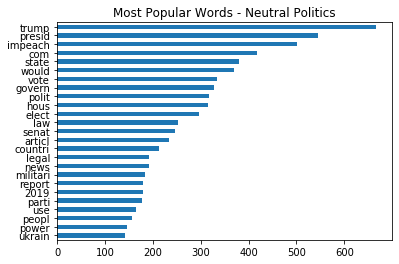

In [314]:
neutralpolitics_df.sum().sort_values().tail(25).plot.barh(title='Most Popular Words - Neutral Politics');
plt.savefig('Most Popular Words Neutral Politics.png')

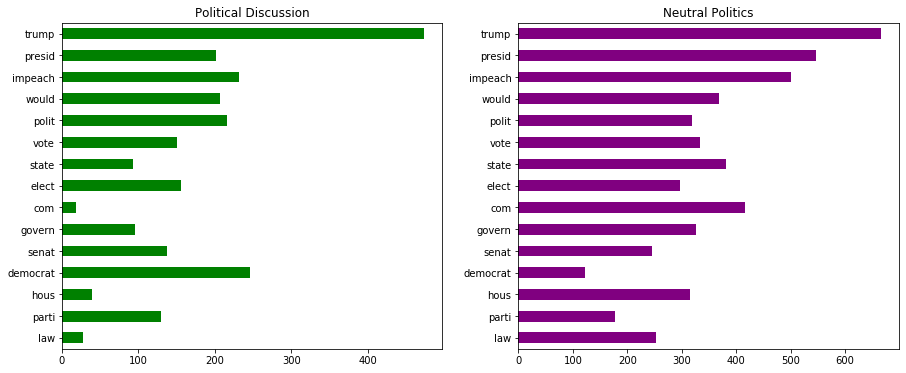

In [315]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6));

political_disc_df.loc[:, political_disc_df_top_words].sum().plot.barh(ax=ax1, color='green')
neutralpolitics_df.loc[:, neutralpolitics_df_top_words].sum().plot.barh(ax=ax2, color='purple')

ax1.set_title('Political Discussion')
ax2.set_title('Neutral Politics');
plt.savefig('Word Counts of Most Popular Across Both Subreddits Total.png')

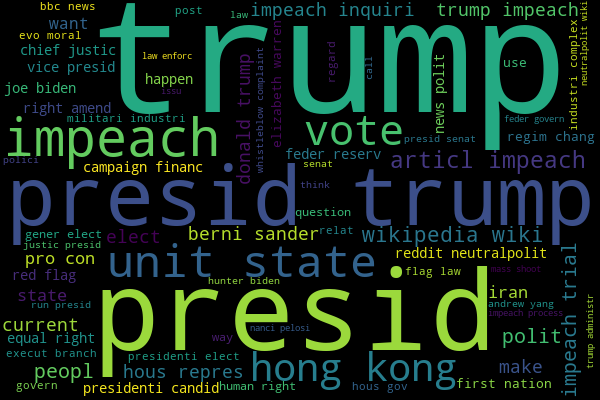

In [320]:
wc = wordcloud.WordCloud(height=400, width=600, max_words=75, min_word_length=3)
text = model_df['selftext_and_title'].str.cat()
wc.generate_from_text(text);
wc.to_image()

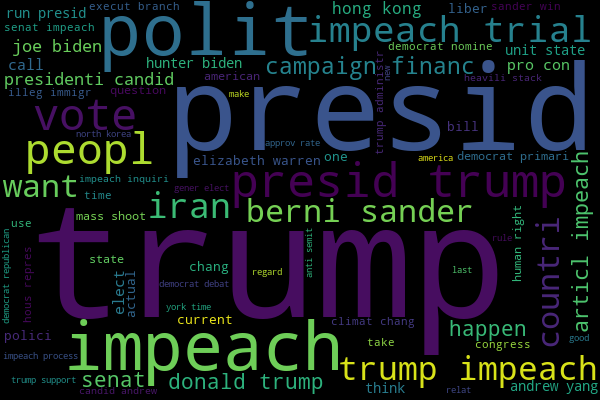

In [321]:
text_title_only = model_df['title'].str.cat()
wc.generate_from_text(text_title_only);
wc.to_image()

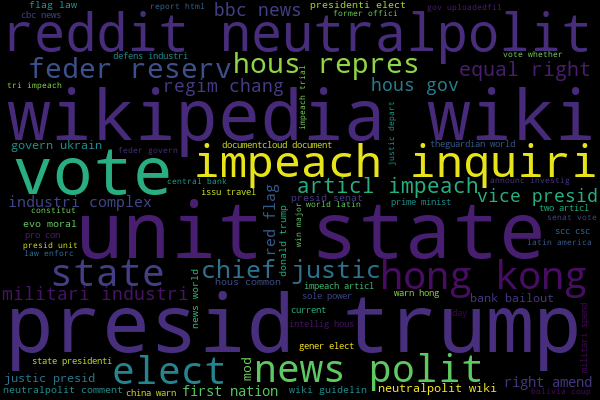

In [322]:
text_selftext_only = model_df['selftext'].str.cat()
wc.generate_from_text(text_selftext_only)
wc.to_image()

### Train, Test, Split & Transformed Versions of the Data

In [323]:
X_train, X_test, y_train, y_test = train_test_split(model_df['selftext_and_title'],
                                                    model_df['subreddit'],
                                                    test_size = 0.33,
                                                    random_state = 78741)

In [324]:
# Beginning with Default Vectorizers
cvec = CountVectorizer()
tfidf = TfidfVectorizer()

# Setting up cvec & tfidf X data
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Final Modeling

## Basic Logistic Regression

In [1]:
# Instantiate basic logistic regression model.
lr = LogisticRegression(solver='lbfgs')

# Fit model to training data.
lr.fit(X_train_cvec, y_train) # generally train_data_features would be X_train

print(f'Logisitic Regression Training Score: {lr.score(X_train_cvec, y_train)}')
lr.score(X_train_cvec, y_train) # default is accuracy for classification models
print(f'Logisitic Regression Cvec Test Score: {lr.score(X_test_cvec, y_test)}')

lr.fit(X_train_tfidf, y_train) # generally train_data_features would be X_train
print(f'Logisitic Regression TFIDF Test Score: {lr.score(X_test_tfidf, y_test)}')

NameError: name 'LogisticRegression' is not defined

#### Count Vectorizer & Logistic Regression Pipeline

In [342]:
# pipe_cvec_logreg = Pipeline([ # Instantiate Transformer and Estimator in Pipeline Variable
#     ('cvec', CountVectorizer()),
#     ('logreg', LogisticRegression(solver='liblinear'))
# ]) # Syntax is annoying tuples of names in a  list

# pipe_cvec_logreg_params = { # Set transformer and estimator pipeline parameters
#     'cvec__max_features': [100, 500, 1000, 2000],
#     'cvec__min_df': [2, 3],
#     'cvec__max_df': [.9, .95],
#     'cvec__ngram_range': [(1,1), (1,2)],
#     'logreg__penalty' : ('l1', 'l2'),
#     'logreg__C' : (1e9, 1, .1, .01)
# }

# # Instantiating GridSearchCV with our pipe and params.
# gs_cvec_logreg = GridSearchCV(pipe_cvec_logreg, # what object are we optimizing?
#                   pipe_cvec_logreg_params, # what parameters values are we searching?
#                   cv = 5) # 5-fold cross-validation.

# # Fit GridSearch to training data. LogReg is pretty quick
# gs_cvec_logreg.fit(X_train, y_train)
# t0 = time.time()
# print(f' Time in seconds elapsed: {time.time() - t0}') # How many seconds elapsed

#### TFIDF Vectorizer & Logistic Regression Pipeline

In [343]:
# # Making and instantiating Pipeline
# pipe_tfidf_logreg = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('logreg', LogisticRegression(solver='liblinear'))
    
# ]) 

# # Setting parameters of pipeline transformers
# pipe_tfidf_logreg_params = {
#     'tfidf__max_features': [100, 500, 1000, 2000], # max features in the corpus
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'tfidf__min_df': [2, 3],
#     'tfidf__max_df': [.9, .95],
#     'logreg__penalty' : ('l1', 'l2'),
#     'logreg__C' : (1e9, 1, .1, .01)
# }
# # Instantiating GridSearchCV with our pipe and params.
# gs_tfidf_logreg = GridSearchCV(pipe_tfidf_logreg, # what object are we optimizing?
#                   pipe_tfidf_logreg_params, # what parameters values are we searching?
#                   cv = 5) # 5-fold cross-validation.

# gs_tfidf_logreg.fit(X_train, y_train)
# print(f' Time in seconds elapsed: {time.time() - t0}') # How many seconds elapsed

In [344]:
# print(f'CVec & Logreg Grid Search Test Score: {gs_cvec_logreg.score(X_test, y_test)}')
# print(f'TFIDF & Logreg Grid Search Test Score: {gs_tfidf_logreg.score(X_test, y_test)}')


# print(f'CVec & Logreg Grid Search Best Params: {gs_cvec_logreg.best_params_}')
# print(f'TFIDF & Logreg Grid Search Best Params: {gs_tfidf_logreg.best_params_}')

### Multinomial Naive Bayes

In [345]:
mnb_cvec = MultinomialNB()
mnb_cvec.fit(X_train_cvec, y_train)
mnb_cvec.score(X_test_cvec, y_test)

0.8191919191919191

In [346]:
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train_tfidf, y_train)
mnb_tfidf.score(X_test_tfidf, y_test)

0.8611111111111112

## Support Vector Machines Cvec & TFIDF

In [348]:
svc_cvec = SVC(gamma='scale')
svc_cvec.fit(X_train_cvec, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [349]:
svc_tfidf = SVC(gamma='scale')
svc_tfidf.fit(X_train_tfidf, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [350]:
print(f'Support Vector CVEC Score: {svc_cvec.score(X_test_cvec, y_test)}')
print(f'Support Vector TFIDF Score: {svc_tfidf.score(X_test_tfidf, y_test)}')

Support Vector CVEC Score: 0.8661616161616161
Support Vector TFIDF Score: 0.9681818181818181
